Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 22-June-2025

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import itertools
import networkx as nx
import random
import seaborn as sns
import cmocean
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

C:\Users\Chris\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set parameters 
data_dir = r'Z:/Data/Roadrunner/Connectomics/'
syn_prediction = 'princeton' # 'Princeton' for dataset from October 2024
syn_thresh = 5
nt_type_score_thresh = 0.62
nt_inhibitory_effect = ['GABA','GLUT']
shuffle = False # True
n_iterations = 1 # 10000
source_neurons = 'RR_BPN' # 'RR' or 'RR_BPN'

In [4]:
# Set source neurons
dict_nodes = {}

if source_neurons == 'RR':
    dict_nodes['source_1'] = [720575940639781027]
    dict_nodes['source_2'] = [720575940633362145] 
elif source_neurons == 'RR_BPN':
    dict_nodes['source_1'] = [720575940639781027, 720575940633362145] # RR
    dict_nodes['source_2'] = [720575940618197840, 720575940625414666, 720575940626598233, # BPN1
                              720575940624589287, 720575940611509485, 720575940610485458, 
                              720575940651418102, 720575940605743648, 720575940622391019, 
                              720575940628859751, 720575940622513524, 720575940627667450,
                              720575940604102880, 720575940618111889, # BPN1 (SMP461)
                              720575940611555251, 720575940628527607, 720575940616070283, # BPN2
                              720575940622022071, 720575940632802785, 720575940630915791,
                              720575940643446638, 720575940630460975,
                              720575940628490028, 720575940630439471, 720575940615192588, # BPN3
                              720575940634714804, 
                              720575940603250860, 720575940630655007, 720575940617330107, # BPN4 
                              720575940613107119, 720575940626797384, 720575940623225417]
else:
    print('Error')

source_nodes = list(itertools.chain(*list(dict_nodes.values())))

In [5]:
# Load connectivity 
if syn_prediction == 'princeton':
    df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections_princeton_no_threshold.csv')
    df_connectivity = df_connectivity.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")
else:
    df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections_no_threshold.csv')
    
# Load neuron classifications 
df_class = pd.read_csv(data_dir + 'flywire_v783_classification.csv')

# Load neurotransmitter information 
df_nt = pd.read_csv(data_dir + 'flywire_v783_neurons.csv')

In [6]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [7]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]
df_connectivity

,pre_root_id,post_root_id,syn_count
19908178,720575940650935673,720575940640736371,2615
12504283,720575940628069501,720575940633305681,2593
19412522,720575940644702112,720575940625952755,2214
8837695,720575940623475324,720575940627497244,2158
9679100,720575940624547622,720575940620975696,2039
...,...,...,...
6606526,720575940620812709,720575940617833867,5
105,720575940597856265,720575940611563310,5
20152247,720575940661338497,720575940620627035,5
6606574,720575940620812709,720575940624456586,5


In [8]:
# Applying a synapse threshold can remove source IDs from the connectivity dataframe. Update source IDs accordingly.
source_nodes = [node for node in source_nodes if node in df_connectivity.pre_root_id.unique().tolist()]

In [9]:
# Get all root IDs
all_nodes = pd.unique(df_connectivity[['pre_root_id', 'post_root_id']].values.ravel('K')) 

In [10]:
# Build network graph
net = nx.DiGraph() 

# Add nodes
net.add_nodes_from(all_nodes)

# Add edges
for index, row in tqdm(df_connectivity.iterrows(), total=len(df_connectivity)): 
    net.add_edge(df_connectivity["pre_root_id"][index], 
                 df_connectivity["post_root_id"][index], 
                 weight=int(df_connectivity.syn_count[index]))   

100%|█████████████████████████████████████████████████████████████████████| 3718216/3718216 [01:40<00:00, 36866.26it/s]


In [11]:
# Get potential target IDs 
potential_target_nodes = df_class.root_id[df_class.super_class=='descending'].tolist()

# Include only target IDs that are in the synapse-thresholded dataframe
post_root_ids = df_connectivity.post_root_id.unique().tolist()
potential_target_nodes = [node for node in potential_target_nodes if node in post_root_ids]
del post_root_ids

In [12]:
len(potential_target_nodes)

1287

In [13]:
# Find paths from source nodes to target nodes
path_length = 2 # Number of hops
intermediary_nodes = []
target_nodes = []

for source_node in source_nodes:
    for potential_target_node in potential_target_nodes: 
        if nx.has_path(net, source_node, potential_target_node):
            for path in nx.all_simple_paths(net, source_node, potential_target_node, cutoff=path_length):
                if len(path)==2:
                    target_nodes.append(path[-1])
                if len(path)==3:
                    # Exclude connections via source and target nodes
                    if (path[1] not in potential_target_nodes) and (path[1] not in source_nodes): 
                        intermediary_nodes.append(path[1])
                        target_nodes.append(path[-1])
                
intermediary_nodes = list(np.unique(intermediary_nodes)) 
target_nodes = list(np.unique(target_nodes))

In [14]:
# Confirm that no source node is an intermediary node
for i in source_nodes:
    if i in intermediary_nodes:
        print(i)

In [15]:
# Generate trimmed connectivity dataframe
df_connectivity_trimmed = pd.DataFrame()

df_connectivity_trimmed = pd.concat([df_connectivity_trimmed,
                                     df_connectivity[
                                         ((df_connectivity['pre_root_id'].isin(source_nodes)) & 
                                          (df_connectivity['post_root_id'].isin(intermediary_nodes + target_nodes)))]
                                    ])
df_connectivity_trimmed = pd.concat([df_connectivity_trimmed, 
                                     df_connectivity[
                                         ((df_connectivity['pre_root_id'].isin(intermediary_nodes)) &
                                          (df_connectivity['post_root_id'].isin(target_nodes)))]       
                                    ])

df_connectivity_trimmed

,pre_root_id,post_root_id,syn_count
14723944,720575940630915791,720575940620802836,77
18617671,720575940639781027,720575940604458668,76
14367215,720575940630460975,720575940620802836,62
16326062,720575940633362145,720575940611246810,56
4939713,720575940618197840,720575940604458668,56
...,...,...,...
16450876,720575940633631396,720575940622633716,5
16451115,720575940633631396,720575940624982823,5
16451360,720575940633631396,720575940627044885,5
16452371,720575940633631396,720575940640486488,5


In [227]:
# [print(i) for i in target_nodes if i not in df_connectivity_trimmed.post_root_id.tolist()]

In [228]:
# df_connectivity_trimmed[(df_connectivity_trimmed["pre_root_id"].isin(target_nodes)) & 
#                         (df_connectivity_trimmed["post_root_id"].isin(target_nodes))]

In [16]:
# Get all nodes
nodes = source_nodes + intermediary_nodes + target_nodes

In [17]:
# Generate dataframe with information about each node
index, root_id, nt_type, nt_type_score, super_class, sub_class = [], [], [], [], [], []

node_keys = list(dict_nodes.keys())

for index_node, node in enumerate(nodes):       
    if node in source_nodes:
        super_class_node = "source"
    elif node in intermediary_nodes:
        super_class_node = "intermediary"
    elif node in target_nodes:
        super_class_node = "target"
    else:
        print('Error')
    
    if node in source_nodes: 
        for key in node_keys:
            if node in dict_nodes[key]:
                sub_class_node = key
    else:
        sub_class_node = ""

    nt_type_node = df_nt.nt_type[df_nt.root_id==node].item()
    nt_type_score_node = df_nt.nt_type_score[df_nt.root_id==node].item()
    if pd.isnull(nt_type_node):
        nt_type_node = "unknown"
    elif super_class_node == "intermediary" and nt_type_score_node < nt_type_score_thresh: 
        nt_type_node = "unknown"
        
    index.append(index_node)
    root_id.append(node)
    nt_type.append(nt_type_node)
    nt_type_score.append(nt_type_score_node)
    super_class.append(super_class_node)
    sub_class.append(sub_class_node)
        
        
df_indices = pd.DataFrame()
df_indices["matrix_index"] = index # Note: .index refers to the dataframe index
df_indices["root_id"] = root_id
df_indices["nt_type"] = nt_type
df_indices["nt_type_score"] = nt_type_score
df_indices["super_class"] = super_class
df_indices["sub_class"] = sub_class

In [18]:
# Generate connectivity matrix with output fractions
# Note: This matrix is not an all-to-all adjacency matrix because 
# it contains only 2-hop feedforward connections from source nodes

conn_mat_fractional_outputs = np.zeros((len(nodes),len(nodes)))
for index_pre_node, node in enumerate(nodes):
    # Get total number of output synapses of pre node 
    n_outputs = df_connectivity.syn_count[(df_connectivity['pre_root_id'] == node)].sum()
    
    # Get postsynaptic connectivity of pre node in trimmed dataframe
    df = df_connectivity_trimmed[(df_connectivity_trimmed['pre_root_id'] == node)]
    
    for row_index, row in df.iterrows():
        syn_count = row["syn_count"]
        post_node = row["post_root_id"]
        index_post_node = nodes.index(post_node)
        
        conn_mat_fractional_outputs[index_pre_node,index_post_node] += syn_count/n_outputs    

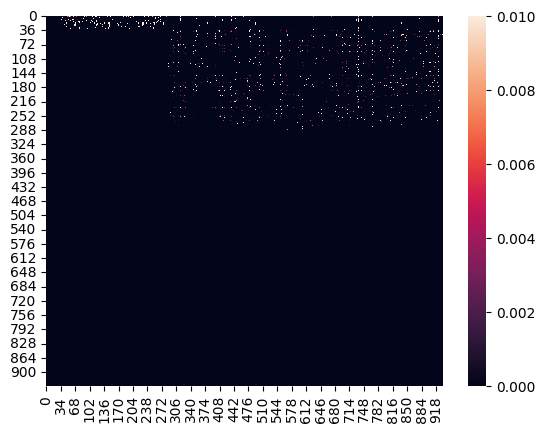

In [19]:
# Plot connectivity matrix
sns.heatmap(conn_mat_fractional_outputs, vmax=0.01);

In [21]:
# Compute output from source nodes onto intermediary nodes and target nodes
# Optional: Shuffle output connections of each source node
shared_source_1_output = []
shared_source_2_output = []

for iteration in tqdm(range(n_iterations)):
    
    # Shuffle output connections of each source node
    conn_mat_shuffled = conn_mat_fractional_outputs.copy()

    if shuffle:
        source_indices = df_indices.index[df_indices["super_class"]=="source"].tolist()
        for index in source_indices:
            # Shuffle output onto intermediary and target nodes
            post_index = list(range(len(source_nodes), len(nodes)))
            post_index = random.shuffle(post_index)

            conn_mat_shuffled[index, len(source_nodes):] = conn_mat_shuffled[index, post_index] 
        
        
    # Classify intermediary nodes 
    intermediary_indices = df_indices.index[df_indices["super_class"]=="intermediary"].tolist()
    
    source_1_indices = df_indices.index[df_indices["sub_class"]=="source_1"].tolist()
    source_2_indices = df_indices.index[df_indices["sub_class"]=="source_2"].tolist()

    for index in intermediary_indices:        
        any_source_1_input = any(conn_mat_shuffled[source_1_indices, index]>0)
        any_source_2_input = any(conn_mat_shuffled[source_2_indices, index]>0)

        if any_source_1_input and any_source_2_input:
            sub_class = "intermediary_12"
        elif any_source_1_input and not any_source_2_input: 
            sub_class = "intermediary_1"
        elif any_source_2_input and not any_source_1_input: 
            sub_class = "intermediary_2"
        else:
            sub_class = "intermediary_other"

        #df_indices.sub_class[df_indices["matrix_index"]==index] = sub_class
        df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = sub_class

     # Note: When connections are shuffled, some intermediary nodes are no longer connected to source nodes
     #if "intermediary_other" in df_indices.sub_class.unique().tolist():
     #    print("Some intermediary neurons not connected to source neurons")
    
        
    # Classify target nodes 
    target_indices = df_indices.index[df_indices["super_class"]=="target"].tolist()
    
    source_1_indices = df_indices.index[(df_indices["sub_class"]=="source_1") |
                                        (df_indices["sub_class"]=="intermediary_1")].tolist()
    source_2_indices = df_indices.index[(df_indices["sub_class"]=="source_2") |
                                        (df_indices["sub_class"]=="intermediary_2")].tolist()
    source_12_indices = df_indices.index[df_indices["sub_class"]=="intermediary_12"].tolist()

    for index in target_indices:
        any_source_1_input = any(conn_mat_shuffled[source_1_indices, index]>0)
        any_source_2_input = any(conn_mat_shuffled[source_2_indices, index]>0)
        any_source_12_indices = any(conn_mat_shuffled[source_12_indices, index]>0)

        if (any_source_1_input and any_source_2_input) or any_source_12_indices:
            sub_class = "target_12"
        else: 
            sub_class = "target_other"

        #df_indices.sub_class[df_indices["matrix_index"]==index] = sub_class
        df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = sub_class

    
    # Further classify intermediary nodes 
    target_12_indices = df_indices.index[df_indices["sub_class"]=="target_12"].tolist()

    intermediary_1_indices = df_indices.index[df_indices["sub_class"]=="intermediary_1"].tolist()
    intermediary_2_indices = df_indices.index[df_indices["sub_class"]=="intermediary_2"].tolist()    

    for index in intermediary_1_indices:
        any_shared_output = any(conn_mat_shuffled[index, target_12_indices]>0)    
        if any_shared_output: 
             #df_indices.sub_class[df_indices["matrix_index"]==index] = "intermediary_1_shared"
             df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = "intermediary_1_shared"


    for index in intermediary_2_indices:
        any_shared_output = any(conn_mat_shuffled[index, target_12_indices]>0)   
        if any_shared_output: 
             #df_indices.sub_class[df_indices["matrix_index"]==index] = "intermediary_2_shared"
             df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = "intermediary_2_shared"
  
                
    # Further classify target nodes 
    target_other_indices = df_indices.index[df_indices["sub_class"]=="target_other"].tolist()

    # Note: After previous classification, intermediary_1 and intermediary_2 do not project to target_12 
    source_1_indices = df_indices.index[(df_indices["sub_class"]=="source_1") |
                                        (df_indices["sub_class"]=="intermediary_1") | 
                                        (df_indices["sub_class"]=="intermediary_1_shared")].tolist()
    source_2_indices = df_indices.index[(df_indices["sub_class"]=="source_2") |
                                        (df_indices["sub_class"]=="intermediary_2") |
                                        (df_indices["sub_class"]=="intermediary_2_shared")].tolist()

    for index in target_other_indices:
        any_source_1_input = any(conn_mat_shuffled[source_1_indices, index]>0)
        any_source_2_input = any(conn_mat_shuffled[source_2_indices, index]>0)

        if any_source_1_input and not any_source_2_input:
            sub_class = "target_1"
        elif any_source_2_input and not any_source_1_input:
            sub_class = "target_2"
        else:
            sub_class = "target_other"

        #df_indices.sub_class[df_indices["matrix_index"]==index] = sub_class
        df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = sub_class
   
    
    # Get summed relative output of source_1 onto shared pathways
    source_indices = df_indices.index[df_indices["sub_class"]=="source_1"].tolist()
    shared_indices = df_indices.index[(df_indices["sub_class"]=="intermediary_12") |
                                      (df_indices["sub_class"]=="intermediary_1_shared") | 
                                      (df_indices["sub_class"]=="target_12")].tolist()

    shared_source_1_output.append(np.mean(np.sum(conn_mat_shuffled[source_indices,:][:,shared_indices],axis=1)))
    
    # Get summed relative output of source_2 onto shared pathways
    source_indices = df_indices.index[df_indices["sub_class"]=="source_2"].tolist()
    shared_indices = df_indices.index[(df_indices["sub_class"]=="intermediary_12") |
                                      (df_indices["sub_class"]=="intermediary_2_shared") | 
                                      (df_indices["sub_class"]=="target_12")].tolist()

    shared_source_2_output.append(np.mean(np.sum(conn_mat_shuffled[source_indices,:][:,shared_indices],axis=1)))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


In [236]:
# # Store dataframe
# df_indices.to_csv('df_indices_RR_BPN.csv')

In [22]:
print(shared_source_1_output)

[np.float64(0.9950657894736841)]


In [23]:
print(shared_source_2_output)

[np.float64(0.8702346723371994)]


In [239]:
# # Get median instead of mean 
# source_indices = df_indices.index[df_indices["sub_class"]=="source_2"].tolist()
# shared_indices = df_indices.index[(df_indices["sub_class"]=="intermediary_12") |
#                                   (df_indices["sub_class"]=="intermediary_2_shared") | 
#                                   (df_indices["sub_class"]=="target_12")].tolist()
# 
# np.median(np.sum(conn_mat_shuffled[source_indices,:][:,shared_indices],axis=1))

In [240]:
# # Plot distribution of shared output 
# binwidth = 0.01
# plt.hist(shared_source_1_output, bins=np.arange(0-binwidth/2, 1+binwidth/2+binwidth, binwidth), density=True)
# plt.xlim([0,1])
# print(np.mean(shared_source_1_output))

In [24]:
# Add group label for pooling nodes below 
group = []

if source_neurons == 'RR_BPN':
    for index, row in df_indices.iterrows():
        sub_class = df_indices.sub_class[index]
        group.append(sub_class)
        
# For RR
#if group_type == 'RR':
#    for index, row in df_indices.iterrows():
#        super_class = df_indices.super_class[index]
#        if super_class == "intermediary":
#            nt_type = df_indices.nt_type[index]
#            if nt_type in ["unknown"]:
#                nt_effect = "unknown"
#            elif nt_type in nt_inhibitory_effect:
#                nt_effect = "inhibitory"
#            else:
#                nt_effect = "excitatory"
#            group.append(super_class + '_' + nt_effect)
#        else:
#            group.append(super_class)

## For RR vs BPN (basis for feedforward pathways)
#for index, row in df_indices.iterrows():
#    sub_class = df_indices.sub_class[index]
#    super_class = df_indices.super_class[index]
#    if super_class == "intermediary":
#        nt_type = df_indices.nt_type[index]
#        if nt_type in ["unknown"]:
#            nt_effect = "unknown"
#        elif nt_type in nt_inhibitory_effect:
#            nt_effect = "inhibitory"
#        else:
#            nt_effect = "excitatory"
#
#        group.append(sub_class + '_' + nt_effect)
#    else:
#        group.append(sub_class)

    
## For RR+BPN vs MT    
#df_highlight = pd.read_csv('df_indices_RR_BPN.csv')    
#ids_highlight = df_highlight.root_id[df_highlight["sub_class"].isin(['intermediary_1_shared',
#                                                                     'intermediary_12',
#                                                                     'intermediary_2_shared',
#                                                                     'target_12'])].tolist()
#for index, row in df_indices.iterrows():
#    sub_class = df_indices.sub_class[index]
#    super_class = df_indices.super_class[index]
#    
#    root_id = df_indices.root_id[index]
#    tag = ''
#    if root_id in ids_highlight:
#        tag = '_highlight'          
#    group.append(sub_class + tag)

df_indices["group"] = group 

In [25]:
df_indices

,matrix_index,root_id,nt_type,nt_type_score,super_class,sub_class,group
0,0,720575940639781027,ACH,0.79,source,source_1,source_1
1,1,720575940633362145,ACH,0.83,source,source_1,source_1
2,2,720575940618197840,ACH,0.87,source,source_2,source_2
3,3,720575940625414666,ACH,0.79,source,source_2,source_2
4,4,720575940626598233,ACH,0.81,source,source_2,source_2
...,...,...,...,...,...,...,...
930,930,720575940653310198,GLUT,0.88,target,target_12,target_12
931,931,720575940653614838,unknown,0.00,target,target_12,target_12
932,932,720575940654094241,GABA,0.53,target,target_2,target_2
933,933,720575940655587489,ACH,0.83,target,target_2,target_2


In [26]:
# Generate all-to-all connectivity matrix for neuron groups (specified above) with merged fractional output
groups = df_indices.group.unique().tolist()
conn_mat_group_fractional_outputs = np.zeros((len(groups), len(groups)))

for group_index, group in enumerate(groups):
    pre_root_ids = df_indices.root_id[df_indices['group']==group].tolist()
    
    # Get total number of output synapses of pre root IDs from un-trimmed connectivity dataframe
    n_outputs = df_connectivity.syn_count[(df_connectivity['pre_root_id'].isin(pre_root_ids))].sum()
    
    # Get all post root IDs of pre root IDs 
    df = df_connectivity[(df_connectivity['pre_root_id'].isin(pre_root_ids)) 
                        & df_connectivity['post_root_id'].isin(nodes)]
        
    # Sum synapses for pre root IDs
    df = df.groupby(['post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

    # Loop over post root IDs
    for index, row in df.iterrows():
        post_root_id = df.post_root_id[index]
        rel_weight = df.syn_count[index] / n_outputs
        
        post_root_id_group = df_indices.group[df_indices["root_id"]==post_root_id].item()
        if post_root_id_group in groups:
            idx = groups.index(post_root_id_group)
            conn_mat_group_fractional_outputs[group_index,idx] += rel_weight

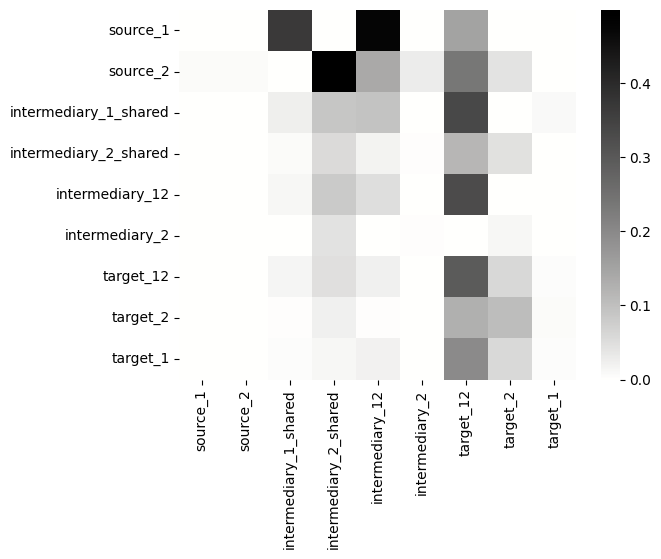

In [27]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r
sns.heatmap(conn_mat_group_fractional_outputs, 
            xticklabels = groups, 
            yticklabels = groups,
            cmap = cmap)
plt.show()

In [28]:
# Display number of neurons per group 
groups = df_indices.group.unique().tolist()
for group in groups:
    n = len(df_indices[df_indices["group"]==group])
    print(group + ': ' + str(n))

source_1: 2
source_2: 32
intermediary_1_shared: 51
intermediary_2_shared: 157
intermediary_12: 30
intermediary_2: 16
target_12: 350
target_2: 281
target_1: 16


In [29]:
# Calculate output of neurons in specific group 

# # RR
#pre_index = [group_index for group_index, group in enumerate(groups) if 'source' in group]
#post_index = [group_index for group_index, group in enumerate(groups) if 'target' in group]
# np.median(np.sum(conn_mat_group_fractional_outputs[pre_index,:][:,post_index],axis=1))

# RR+BPN vs MT
pre_index = groups.index("source_1")
post_index = groups.index("intermediary_12") 
np.sum(conn_mat_group_fractional_outputs[pre_index,post_index]) 

np.float64(0.47709049255440983)

In [30]:
# Get root IDs of neurons in specific group
root_ids = df_indices.root_id[df_indices["group"]=="intermediary_12"].tolist()
# [print(i) for i in root_ids]

nt_types = []
super_class = []
for root_id in root_ids:
    nt_types.append(df_indices.nt_type[df_indices.root_id==root_id].item())
    super_class.append(df_class.super_class[df_class.root_id==root_id].item())
    
values, counts = np.unique(super_class, return_counts=True)
print(values)
print(counts/len(super_class))

['central']
[1.]


In [31]:
# Generate connectivity matrix with input fractions
conn_mat_fractional_inputs = np.zeros((len(nodes),len(nodes)))
for index_post_node, node in enumerate(nodes):
    # Get total number of input synapses of node 
    n_inputs = df_connectivity.syn_count[(df_connectivity['post_root_id'] == node)].sum()
    
    # Get presynaptic connectivity of node in trimmed dataframe
    df = df_connectivity_trimmed[(df_connectivity_trimmed['post_root_id'] == node)]
    
    for row_index, row in df.iterrows():
        syn_count = row["syn_count"]
        pre_node = row["pre_root_id"]
        index_pre_node = nodes.index(pre_node)
        
        conn_mat_fractional_inputs[index_pre_node,index_post_node] += syn_count/n_inputs

In [32]:
# Trim connectivity matrix to shared pathways and add inhibitory effect

if source_neurons == 'RR':
    sub_classes = df_indices.sub_class.unique().tolist()

elif source_neurons == 'RR_BPN':
    # For RR vs BPN, select only shared pathways
    sub_classes = ["source_1", 
                   "source_2", 
                   "intermediary_12", 
                   "intermediary_1_shared", 
                   "intermediary_2_shared", 
                   "target_12"]

# # For RR+BPN vs MT
# sub_classes = ["source_1", 
#               "source_2", 
#               "intermediary_1_highlight", 
#               "intermediary_1_shared_highlight",
#               "intermediary_12_highlight",
#               "intermediary_2_shared", 
#               "target_1_highlight",
#               "target_12_highlight",
#               "target_12"]

conn_mat_shared = conn_mat_fractional_inputs.copy()
indices_to_keep = []

for index in range(len(df_indices)):
    # For RR and RR vs BPN: sub_class = df_indices.sub_class[index]
    # For RR+BPN vs MT: sub_class = df_indices.group[index]
    sub_class = df_indices.sub_class[index]
    nt_type = df_indices.nt_type[index]
    
    if sub_class in sub_classes:
        indices_to_keep.append(index)      
    
    # Set outputs of neurons with unknown neurotransmitter to zero. 
    # Note that only intermediary neurons with a prediction score smaller nt_score_thresh are set to 'unknown' above.
    if nt_type == 'unknown':
        conn_mat_shared[index,:] = conn_mat_shared[index,:]*0
    
    # Make inhibitory connections negative
    if nt_type in nt_inhibitory_effect:
        conn_mat_shared[index,:] = conn_mat_shared[index,:]*-1
    
# Trim matrix 
conn_mat_shared = conn_mat_shared[np.array(indices_to_keep),:][:,np.array(indices_to_keep)]

In [33]:
# Generate new version of df_indices for conn_mat_shared
df_indices_shared = df_indices[df_indices["matrix_index"].isin(indices_to_keep)]
df_indices_shared["matrix_index"] = indices_to_keep
df_indices_shared = df_indices_shared.reset_index(drop=True)
df_indices_shared

,matrix_index,root_id,nt_type,nt_type_score,super_class,sub_class,group
0,0,720575940639781027,ACH,0.79,source,source_1,source_1
1,1,720575940633362145,ACH,0.83,source,source_1,source_1
2,2,720575940618197840,ACH,0.87,source,source_2,source_2
3,3,720575940625414666,ACH,0.79,source,source_2,source_2
4,4,720575940626598233,ACH,0.81,source,source_2,source_2
...,...,...,...,...,...,...,...
617,924,720575940647586948,ACH,0.91,target,target_12,target_12
618,926,720575940648636292,GLUT,0.60,target,target_12,target_12
619,928,720575940650929273,DA,0.54,target,target_12,target_12
620,930,720575940653310198,GLUT,0.88,target,target_12,target_12


In [34]:
# Compute connectivity strength
conn_mat_shared_one_hop = conn_mat_shared.copy() 
conn_mat_shared_two_hops = np.matmul(conn_mat_shared_one_hop, conn_mat_shared_one_hop)
conn_mat_shared_one_two_hops = conn_mat_shared_one_hop + conn_mat_shared_two_hops

In [35]:
def sort_nodes(conn_mat,source_indices,target_indices):
    
    conn_strength = conn_mat[source_indices[0],target_indices]
    for index, source_index in enumerate(source_indices):
        if index>0:
            conn_strength += conn_mat[source_index,target_indices]
    
    target_indices_sorted = (-conn_strength).argsort()  
    conn_strength_sorted = conn_strength[target_indices_sorted]
    
    return target_indices_sorted, conn_strength_sorted

In [36]:
# Build dataframe with target nodes ranked based on connectivity strength

if source_neurons == 'RR':
    target_indices = df_indices_shared.index[df_indices_shared["super_class"] == "target"].tolist()
    target_ids = df_indices_shared.root_id[df_indices_shared["super_class"] == "target"].tolist()
    
elif source_neurons == 'RR_BPN':
    # For RR vs BPN, select only shared targets
    target_indices = df_indices_shared.index[df_indices_shared["sub_class"] == "target_12"].tolist()
    target_ids = df_indices_shared.root_id[df_indices_shared["sub_class"] == "target_12"].tolist()


# Rank target nodes based on combined connectivity strength from source_1 and source_2
source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_1","source_2"])].tolist()
target_indices_sorted, conn_strength_sorted = sort_nodes(conn_mat_shared_one_two_hops, source_indices, target_indices)
target_ids_sorted = [target_ids[index] for index in target_indices_sorted]

# Rank target nodes based on connectivity strength from source_1
source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_1"])].tolist()
target_indices_sorted_source_1, conn_strength_sorted_source_1 = sort_nodes(conn_mat_shared_one_two_hops, source_indices, target_indices)

# Rank target nodes based on connectivity strength from source_2
source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_2"])].tolist()
target_indices_sorted_source_2, conn_strength_sorted_source_2 = sort_nodes(conn_mat_shared_one_two_hops, source_indices, target_indices)


# Build dataframe
df_targets_ranked = pd.DataFrame()
df_targets_ranked['root_id'] = target_ids_sorted

df_targets_ranked['rank_source_12'] = np.linspace(1, len(target_ids_sorted), len(target_ids_sorted)).astype(int)
df_targets_ranked['conn_strength_source_12'] = conn_strength_sorted

map_index = [np.argwhere(target_indices_sorted_source_1 == index)[0][0] for index in target_indices_sorted]
df_targets_ranked['rank_source_1'] = map_index
df_targets_ranked['rank_source_1'] += 1
df_targets_ranked['conn_strength_source_1'] = conn_strength_sorted_source_1[map_index] 

map_index = [np.argwhere(target_indices_sorted_source_2 == index)[0][0] for index in target_indices_sorted]
df_targets_ranked['rank_source_2'] = map_index
df_targets_ranked['rank_source_2'] += 1
df_targets_ranked['conn_strength_source_2'] = conn_strength_sorted_source_2[map_index]
df_targets_ranked

,root_id,rank_source_12,conn_strength_source_12,rank_source_1,conn_strength_source_1,rank_source_2,conn_strength_source_2
0,720575940622010373,1,0.051274,325,-0.000318,1,0.051592
1,720575940609376707,2,0.030514,4,0.010703,5,0.019810
2,720575940638204132,3,0.028525,341,-0.001506,2,0.030031
3,720575940617952034,4,0.024571,3,0.011563,11,0.013009
4,720575940639242303,5,0.023777,192,0.000000,3,0.023777
...,...,...,...,...,...,...,...
345,720575940634560922,346,-0.003903,348,-0.002564,333,-0.001339
346,720575940610472146,347,-0.005311,346,-0.002324,347,-0.002987
347,720575940640747352,348,-0.006572,349,-0.002786,348,-0.003786
348,720575940639428174,349,-0.009084,347,-0.002395,350,-0.006689


In [59]:
# Add relative input from shared circuit neurons
syn_count_shared_rel = []

pre_ids = df_indices_shared.root_id[df_indices_shared.group.isin(['source_1','source_2','intermediary_12','intermediary_1_shared','intermediary_2_shared'])].tolist()
target_ids = df_targets_ranked.root_id.tolist()
for target_id in target_ids:
    syn_count_total = df_connectivity.syn_count[df_connectivity.post_root_id==target_id].sum().item()
    syn_count_shared = df_connectivity.syn_count[(df_connectivity.post_root_id==target_id) & (df_connectivity.pre_root_id.isin(pre_ids))].sum().item()
    syn_count_shared_rel.append(syn_count_shared/syn_count_total)

df_targets_ranked['syn_count_shared_rel'] = syn_count_shared_rel

In [60]:
df_targets_ranked

,root_id,rank_source_12,conn_strength_source_12,rank_source_1,conn_strength_source_1,rank_source_2,conn_strength_source_2,syn_count_shared_rel
0,720575940622010373,1,0.051274,325,-0.000318,1,0.051592,0.147687
1,720575940609376707,2,0.030514,4,0.010703,5,0.019810,0.106188
2,720575940638204132,3,0.028525,341,-0.001506,2,0.030031,0.204113
3,720575940617952034,4,0.024571,3,0.011563,11,0.013009,0.297278
4,720575940639242303,5,0.023777,192,0.000000,3,0.023777,0.247596
...,...,...,...,...,...,...,...,...
345,720575940634560922,346,-0.003903,348,-0.002564,333,-0.001339,0.234000
346,720575940610472146,347,-0.005311,346,-0.002324,347,-0.002987,0.136432
347,720575940640747352,348,-0.006572,349,-0.002786,348,-0.003786,0.290640
348,720575940639428174,349,-0.009084,347,-0.002395,350,-0.006689,0.263467


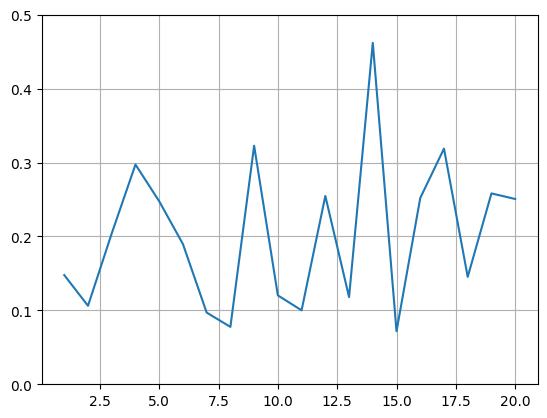

In [74]:
plt.plot(df_targets_ranked.rank_source_12[df_targets_ranked.rank_source_12<21], 
         df_targets_ranked.syn_count_shared_rel[df_targets_ranked.rank_source_12<21])
plt.ylim([0,0.5])
plt.grid()
plt.show()

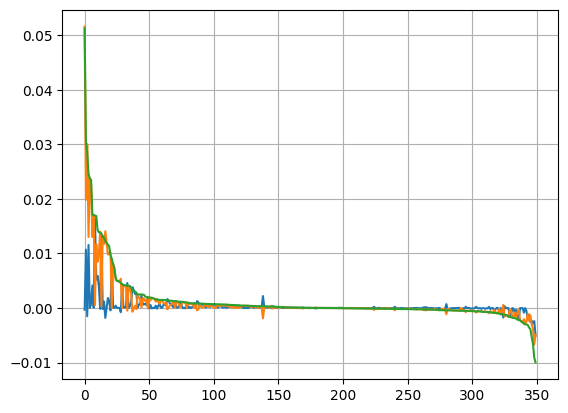

In [38]:
# Plot rankeds nodes 
plt.plot(df_targets_ranked.conn_strength_source_1)
plt.plot(df_targets_ranked.conn_strength_source_2)
plt.plot(df_targets_ranked.conn_strength_source_12)
plt.grid()
#plt.savefig(r"C:\Users\Chris\Desktop\connectivity_strength.eps", transparent=True)
plt.show()

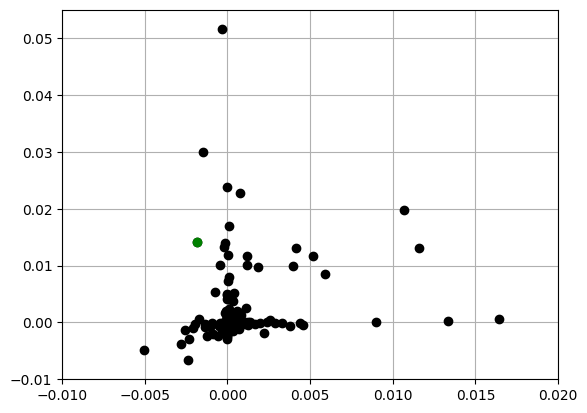

,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
113155,720575940629736720,efferent,descending,NaN,NaN,DNae002,CL124,putative_primary,right,CV


In [79]:
#ranks_to_highlight = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ranks_to_highlight = [17]
plt.plot(df_targets_ranked.conn_strength_source_1, df_targets_ranked.conn_strength_source_2, 'ok')
plt.plot(df_targets_ranked.conn_strength_source_1[df_targets_ranked.rank_source_12.isin(ranks_to_highlight)], 
         df_targets_ranked.conn_strength_source_2[df_targets_ranked.rank_source_12.isin(ranks_to_highlight)], 
         'og')
plt.grid()
plt.xlim([-0.01,0.02])
plt.ylim([-0.01,0.055])
plt.show()

df_class[df_class.root_id == df_targets_ranked.root_id[df_targets_ranked.rank_source_12.isin(ranks_to_highlight)].item()]

In [239]:
# For each target neuron, calculate relative input from shared neurons

df_connectivity.syn_count[df_connectivity.pre_root_id==720575940611813842].sum()

1729

In [240]:
(1499+1729)/2

1614.0

BDN3: 720575940622010373
BDN1: 720575940638204132
BDN1: 720575940630135084
BDN4: 720575940647586948
BDN4: 720575940611813842
BDN2: 720575940640978048
cDN1: 720575940612603289
cDN1: 720575940614730914
BDN2: 720575940647228468
DNg13: 720575940606112940
oDN1: 720575940620300308
DNg13: 720575940616471052
oDN1: 720575940626730883
DNa01: 720575940627787609
DNa01: 720575940644438551
DNa02: 720575940604737708
DNa02: 720575940629327659
DNg60: 720575940635166571
DNg60: 720575940631168057
DNp09: 720575940627652358
DNp09: 720575940635872101
DNa11: 720575940611735514
DNa11: 720575940623019544


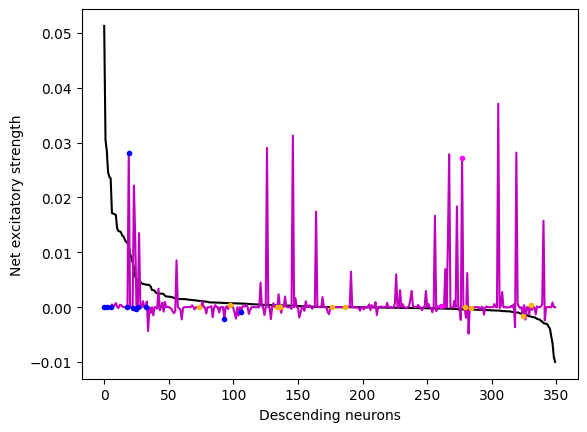

In [276]:
# Plot connectivity strength from source neurons to descending neurons
# Note: .index refers to the dataframe index
source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_1","source_2"])].tolist()

# For RR
#target_indices = df_indices_shared.index[df_indices_shared["super_class"] == "target"].tolist()

# For RR vs BPN 
target_indices = df_indices_shared.index[df_indices_shared["sub_class"] == "target_12"].tolist()
target_ids = df_indices_shared.root_id[df_indices_shared["sub_class"] == "target_12"].tolist()

# For RR+BPN vs MT 
#target_indices = df_indices_shared.index[(df_indices_shared["group"] == "target_12") |
#                                         (df_indices_shared["group"] == "target_1_highlight") |
#                                         (df_indices_shared["group"] == "target_12_highlight")].tolist()

conn_strength = conn_mat_shared_one_two_hops[source_indices[0],target_indices]
for index, source_index in enumerate(source_indices):
    if index>0:
        conn_strength += conn_mat_shared_one_two_hops[source_index,target_indices]

target_sort_index = (-conn_strength).argsort()  
conn_strength_sorted = conn_strength[target_sort_index]
target_ids_sorted = [target_ids[index] for index in target_sort_index]

plt.plot(conn_strength_sorted, 'k')

# Add MT data
df_MT = pd.read_csv(r'C:\Users\Chris\Desktop\MT_DN_conn_strength.csv')
target_ids_MT = df_MT.root_id.tolist()
conn_strength_MT = []
for index, target_id in enumerate(target_ids_sorted):
    if target_id in target_ids_MT:
        conn_strength_MT.append(df_MT.conn_strength[df_MT.root_id==target_id].item())
    else:
        conn_strength_MT.append(0)
        
plt.plot(conn_strength_MT, 'm')

# Add literature data
for index, target_id in enumerate(target_ids_sorted):
    if target_id in literature_ids:
        for key in dict_nodes_literature.keys():
             if target_id in dict_nodes_literature[key]['root_id']:
                print(key + ': ' + str(target_id))
                #plt.plot(index,conn_strength_sorted[index], '.', color=dict_nodes_literature[key]['color'])
                plt.plot(index,conn_strength_MT[index], '.', color=dict_nodes_literature[key]['color'])
                #plt.text(conn_strength_source_1[index], conn_strength_source_2[index], key, color=dict_nodes_literature[key]['color'])

plt.xlabel("Descending neurons")
plt.ylabel("Net excitatory strength")
#plt.savefig(r"C:\Users\Chris\Desktop\connectivity_strength.eps", transparent=True)
plt.show()

In [266]:
df_MT = pd.read_csv(r'C:\Users\Chris\Desktop\MT_DN_conn_strength.csv')
df_MT

,root_id,conn_strength
0,720575940633095137,0.037085
1,720575940632900665,0.031284
2,720575940627015196,0.029058
3,720575940635355804,0.028179
4,720575940611813842,0.028056
...,...,...
320,720575940631643532,-0.002323
321,720575940630106309,-0.002408
322,720575940622321110,-0.003648
323,720575940625539984,-0.004346


In [268]:
target_id = 720575940633095137
df_MT.conn_strength[df_MT.root_id==target_id].item()

0.03708465314

In [233]:
len(target_indices)

325

In [179]:
conn_strength_sorted[:20]

array([0.05127368, 0.03051384, 0.0285246 , 0.02457128, 0.02377686,
       0.02345465, 0.01715675, 0.01706015, 0.01692847, 0.01686241,
       0.01435071, 0.01388057, 0.0138237 , 0.01365382, 0.01303386,
       0.01289464, 0.01225017, 0.01192034, 0.0116343 , 0.01129562])

In [277]:
#[print(i) for i in conn_strength_sorted]

In [182]:
#threshold = 0.8
#y = np.cumsum(conn_strength_sorted)
#y = y/np.max(y)
#print(np.argmax(y>threshold))
#plt.plot(y,'.')
#plt.ylim([0,1.2])
#plt.show()

In [280]:
# Rank target neurons for each source

# # For RR
# target_indices = df_indices_shared.index[df_indices_shared["super_class"] == "target"].tolist()

# For RR vs BPN 
target_indices = df_indices_shared.index[df_indices_shared["sub_class"] == "target_12"].tolist()
target_ids = df_indices_shared.root_id[df_indices_shared["sub_class"] == "target_12"].tolist()

#target_ids_to_include = target_ids_sorted[:20]
#target_indices = df_indices_shared.index[(df_indices_shared["sub_class"] == "target_12") & (df_indices_shared["root_id"].isin(target_ids_to_include))].tolist()

# # For RR+BPN vs MT  
# target_indices = df_indices_shared.index[(df_indices_shared["group"] == "target_12") |
#                                          (df_indices_shared["group"] == "target_1_highlight") |
#                                          (df_indices_shared["group"] == "target_12_highlight")].tolist()

source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_1"])].tolist()
conn_strength_source_1 = conn_mat_shared_one_two_hops[source_indices[0],target_indices]
for index, source_index in enumerate(source_indices):
    if index>0:
        conn_strength_source_1 += conn_mat_shared_one_two_hops[source_index,target_indices]

source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_2"])].tolist()
conn_strength_source_2 = conn_mat_shared_one_two_hops[source_indices[0],target_indices]
for index, source_index in enumerate(source_indices):
    if index>0:
        conn_strength_source_2 += conn_mat_shared_one_two_hops[source_index,target_indices]

target_sort_index_source_1 = (-conn_strength_source_1).argsort()
conn_strength_source_1_sorted = conn_strength_source_1[target_sort_index_source_1]
target_ids_source_1_sorted = [target_ids[index] for index in target_sort_index_source_1]


target_sort_index_source_2 = (-conn_strength_source_2).argsort()
conn_strength_source_2_sorted = conn_strength_source_2[target_sort_index_source_2]
target_ids_source_2_sorted = [target_ids[index] for index in target_sort_index_source_2]


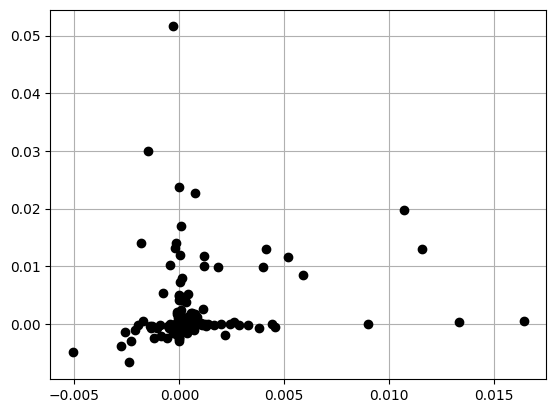

In [279]:
plt.plot(conn_strength_source_1, conn_strength_source_2, 'ok')
plt.plot(conn_strength_source_1, conn_strength_source_2, 'ok')

720575940622010373

#plt.xlim([-0.01,0.02])
#plt.ylim([-0.01,0.055])
plt.grid()
#plt.savefig(r"C:\Users\Chris\Desktop\source_2_vs_source_1_2.eps", transparent=True)
plt.show()

In [286]:
target_ids_sorted

[720575940622010373,
 720575940609376707,
 720575940638204132,
 720575940617952034,
 720575940639242303,
 720575940630135084,
 720575940617399257,
 720575940624766700,
 720575940625513360,
 720575940619038493,
 720575940615092019,
 720575940615378700,
 720575940625489160,
 720575940616886301,
 720575940627790991,
 720575940631333195,
 720575940629736720,
 720575940624402173,
 720575940647586948,
 720575940611813842,
 720575940629846722,
 720575940627732423,
 720575940640978048,
 720575940613088426,
 720575940639726141,
 720575940612603289,
 720575940614730914,
 720575940614137907,
 720575940639789475,
 720575940614089726,
 720575940630334658,
 720575940620298772,
 720575940647228468,
 720575940625295339,
 720575940625539984,
 720575940628881576,
 720575940621566844,
 720575940619486891,
 720575940626092302,
 720575940614186449,
 720575940624877360,
 720575940608188427,
 720575940615715003,
 720575940616286175,
 720575940630803727,
 720575940612036837,
 720575940628030440,
 720575940621

In [285]:
target_ids_source_2_sorted

[720575940622010373,
 720575940638204132,
 720575940639242303,
 720575940630135084,
 720575940609376707,
 720575940624766700,
 720575940629736720,
 720575940625489160,
 720575940627790991,
 720575940617399257,
 720575940617952034,
 720575940624402173,
 720575940631333195,
 720575940619038493,
 720575940629846722,
 720575940611813842,
 720575940615378700,
 720575940647586948,
 720575940615092019,
 720575940640978048,
 720575940613088426,
 720575940639789475,
 720575940639726141,
 720575940612603289,
 720575940614730914,
 720575940614137907,
 720575940630334658,
 720575940625539984,
 720575940620298772,
 720575940647228468,
 720575940628881576,
 720575940621566844,
 720575940608188427,
 720575940640325429,
 720575940615715003,
 720575940624986919,
 720575940612036837,
 720575940628264585,
 720575940628030440,
 720575940616286175,
 720575940622594186,
 720575940618314897,
 720575940607384242,
 720575940632296519,
 720575940641480949,
 720575940625502666,
 720575940621392086,
 720575940626

In [67]:
# Nodes of interest from the literature
dict_nodes_literature = {}
dict_nodes_literature['DNa01'] = {}
dict_nodes_literature['DNa01']['root_id'] = [720575940627787609, 720575940644438551]
dict_nodes_literature['DNa01']['color'] = np.array((1,0.7,0))

dict_nodes_literature['DNa02'] = {}
dict_nodes_literature['DNa02']['root_id'] = [720575940629327659, 720575940604737708]
dict_nodes_literature['DNa02']['color'] = np.array((1,0.7,0))

dict_nodes_literature['DNa11'] = {}
dict_nodes_literature['DNa11']['root_id'] = [720575940611735514, 720575940623019544]
dict_nodes_literature['DNa11']['color'] = np.array((1,0.7,0))

dict_nodes_literature['DNb05'] = {}
dict_nodes_literature['DNb05']['root_id'] = [720575940628352850, 720575940629461442]
dict_nodes_literature['DNb05']['color'] = np.array((1,0.7,0))

dict_nodes_literature['DNb06'] = {}
dict_nodes_literature['DNb06']['root_id'] = [720575940637308605, 720575940629041879]
dict_nodes_literature['DNb06']['color'] = np.array((1,0.7,0))

dict_nodes_literature['DNg13'] = {}
dict_nodes_literature['DNg13']['root_id'] = [720575940616471052, 720575940606112940]
dict_nodes_literature['DNg13']['color'] = np.array((1,0.7,0))

dict_nodes_literature['DNp09'] = {}
dict_nodes_literature['DNp09']['root_id'] = [720575940635872101, 720575940627652358]
dict_nodes_literature['DNp09']['color'] = np.array((1,0.7,0))

dict_nodes_literature['DNg60'] = {}
dict_nodes_literature['DNg60']['root_id'] = [720575940631168057, 720575940635166571] # 'Bluebell'
dict_nodes_literature['DNg60']['color'] = np.array((1,0,1))

dict_nodes_literature['DNg11'] = {}
dict_nodes_literature['DNg11']['root_id'] = [720575940625573653, 720575940618827910, 720575940609366648, 720575940644740256, 
                                             720575940631090402, 720575940621817326]
dict_nodes_literature['DNg11']['color'] = np.array((0,1,0))

dict_nodes_literature['DNg12'] = {}
dict_nodes_literature['DNg12']['root_id'] = [720575940619751872, 720575940611939290, 720575940631987364, 720575940615958203, 
                                             720575940625253649, 720575940631518582, 720575940638810677, 720575940631108559, 
                                             720575940626834698, 720575940620149836, 720575940621640885, 720575940628241628, 
                                             720575940617390641, 720575940617554577, 720575940645032580, 720575940627417619, 
                                             720575940626399588, 720575940614588778, 720575940626527055, 720575940641781133,
                                             720575940605282406, 720575940617074393, 720575940642926702, 720575940624394498, 
                                             720575940625872688, 720575940615623051, 720575940632698541, 720575940619524852, 
                                             720575940618762605, 720575940618147520, 720575940617993607, 720575940611700520, 
                                             720575940625422609, 720575940608960722, 720575940612019825, 720575940622797244, 
                                             720575940635175263, 720575940637501784, 720575940627500279, 720575940621767306,
                                             720575940627814522, 720575940612427670]
dict_nodes_literature['DNg12']['color'] = np.array((0,1,0))

# dict_nodes_literature['DNg02'] = {}
# dict_nodes_literature['DNg02']['root_id'] = [720575940639201443, 720575940612014131, 720575940612804606, 720575940630289804,
#                                              720575940610863310, 720575940632573887, 720575940627414887, 720575940617498507,
#                                              720575940613668620, 720575940613793170, 720575940647964281, 720575940615679282,
#                                              720575940626377349, 720575940627850622, 720575940617922439, 720575940622042603,
#                                              720575940625144061, 720575940626278129, 720575940622910188, 720575940625482954,
#                                              720575940628942586, 720575940630492714, 720575940641305229, 720575940622681864, 
#                                              720575940626904219]
# dict_nodes_literature['DNg02']['color'] = np.array((0.7,0.7,0.7))

dict_nodes_literature['oDN1'] = {}
dict_nodes_literature['oDN1']['root_id'] = [720575940626730883, 720575940620300308]
dict_nodes_literature['oDN1']['color'] = np.array((0,0,1))

dict_nodes_literature['cDN1'] = {}
dict_nodes_literature['cDN1']['root_id'] = [720575940614730914, 720575940612603289]
dict_nodes_literature['cDN1']['color'] = np.array((0,0,1))

dict_nodes_literature['BDN1'] = {}
dict_nodes_literature['BDN1']['root_id'] = [720575940638204132, 720575940630135084]
dict_nodes_literature['BDN1']['color'] = np.array((0,0,1))

dict_nodes_literature['BDN2'] = {}
dict_nodes_literature['BDN2']['root_id'] = [720575940640978048, 720575940647228468]
dict_nodes_literature['BDN2']['color'] = np.array((0,0,1))

dict_nodes_literature['BDN3'] = {}
dict_nodes_literature['BDN3']['root_id'] = [720575940622010373]
dict_nodes_literature['BDN3']['color'] = np.array((0,0,1))

dict_nodes_literature['BDN4'] = {}
dict_nodes_literature['BDN4']['root_id'] = [720575940611813842, 720575940647586948]
dict_nodes_literature['BDN4']['color'] = np.array((0,0,1))

IndexError: index 20 is out of bounds for axis 0 with size 20

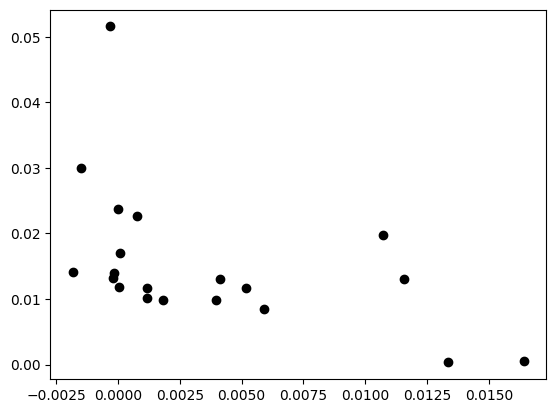

In [172]:
# Plot connectivity strength
thresh = 20

## For RR
#axis_lim = [-0.01,0.02]
#plt.plot(conn_strength_source_1, conn_strength_source_2, 'ok')
#plt.plot([conn_strength_source_1_sorted[thresh], conn_strength_source_1_sorted[thresh]], axis_lim, 'k')
#plt.plot(axis_lim, [conn_strength_source_2_sorted[thresh], conn_strength_source_2_sorted[thresh]], 'k')
#
## Color descending neurons based on axon side
#for index, target_index in enumerate(target_indices):
#    root_id = df_indices_shared.root_id[df_indices_shared.index == target_index].item()
#    if root_id in dict_axon_side['left']:
#        plt.plot(conn_strength_source_1[index], conn_strength_source_2[index], 'o', color='c')
#    if root_id in dict_axon_side['right']:
#        plt.plot(conn_strength_source_1[index], conn_strength_source_2[index], 'o', color='m')


# For RR vs BPN and RR+BPN vs MT
axis_lim = [-0.01,0.055]
#axis_lim = [-0.01,0.02]
plt.plot(conn_strength_source_1, conn_strength_source_2, 'ok')
plt.plot([conn_strength_source_1_sorted[thresh], conn_strength_source_1_sorted[thresh]], axis_lim, 'k')
plt.plot(axis_lim, [conn_strength_source_2_sorted[thresh], conn_strength_source_2_sorted[thresh]], 'k')

# Color descending neurons based on known function  
literature_ids = [(dict_nodes_literature[key]['root_id']) for key in list(dict_nodes_literature.keys())]
literature_ids = list(itertools.chain(*literature_ids))
for index, target_index in enumerate(target_indices):
    root_id = df_indices_shared.root_id[df_indices_shared.index == target_index].item()
    if root_id in literature_ids:
        for key in dict_nodes_literature.keys():
             if root_id in dict_nodes_literature[key]['root_id']:
                plt.plot(conn_strength_source_1[index], conn_strength_source_2[index], 'o', color=dict_nodes_literature[key]['color'])
                plt.text(conn_strength_source_1[index], conn_strength_source_2[index], key, color=dict_nodes_literature[key]['color'])
                #if key=='BDN2':
                #    plt.text(conn_strength_source_1[index], conn_strength_source_2[index], key, color=dict_nodes_literature[key]['color'])
                print(key + ': ' + str(root_id))
            
plt.xlim(axis_lim)
plt.ylim(axis_lim)
#plt.savefig(r"C:\Users\Chris\Desktop\source_2_vs_source_1.png", dpi=300) #, transparent=True, format='eps')
plt.savefig(r"C:\Users\Chris\Desktop\source_2_vs_source_1_2.eps", transparent=True)
plt.show()

In [259]:
# plt.plot(conn_strength_source_2[target_sort_index_source_1], 'm')
# #plt.plot(conn_strength_source_1[target_sort_index_source_1], 'c')
# #plt.xlabel("Descending neurons")
# plt.ylabel("Net excitatory strength")
# plt.legend(['MT','RR+BPN'])
# #plt.savefig(r"C:\Users\Chris\Desktop\RR_BPN_MT.eps")
# plt.show()

In [260]:
# Get IDs of ranked descending neurons 

# Top excited 
target_id_source_1 = [df_indices_shared.root_id[df_indices_shared.index==target_indices[index]].item() for index in target_sort_index_source_1][:20]
target_id_source_2 = [df_indices_shared.root_id[df_indices_shared.index==target_indices[index]].item() for index in target_sort_index_source_2][:20]

# Top inhibited
#target_id_source_1 = [df_indices_shared.root_id[df_indices_shared.index==target_indices[index]].item() for index in target_sort_index_source_1][-20:]
#target_id_source_2 = [df_indices_shared.root_id[df_indices_shared.index==target_indices[index]].item() for index in target_sort_index_source_2][-20:]
#target_id_source_1 = target_id_source_1[::-1]
#target_id_source_2 = target_id_source_2[::-1]

for target_id in target_id_source_1:
    if target_id in target_id_source_2:
        print(target_id)

720575940617952034
720575940609376707
720575940615092019
720575940619038493
720575940617399257
720575940615378700
720575940647586948


In [261]:
[print(i) for i in target_id_source_1]

720575940625513360
720575940616886301
720575940617952034
720575940609376707
720575940627732423
720575940615092019
720575940619038493
720575940625295339
720575940614089726
720575940617399257
720575940615378700
720575940619486891
720575940626092302
720575940624877360
720575940614186449
720575940630803727
720575940617280657
720575940628858640
720575940647586948
720575940640316238


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [262]:
# [print(i) for i in target_id_source_2]

In [263]:
# Get connectivity strength to ranked descending neurons
# Top excited
conn_strength_print = conn_strength_source_2_sorted[:20]

# Top inhibited
#conn_strength_print = conn_strength_source_2_sorted[-20:]
#conn_strength_print = conn_strength_print[::-1]

[print(i) for i in conn_strength_print]

0.05159208845975109
0.030030664269628658
0.023776862477349565
0.022691446746090076
0.019810458867112232
0.016986650667502306
0.014062836431109225
0.013992460377299738
0.013222026434467932
0.013015353615187079
0.01300873681807133
0.01188692532807148
0.01173340950929296
0.011675806085523705
0.010170755517908999
0.010125792249318649
0.009915972848407624
0.009804319568600338
0.008452942463970303
0.008026762090929326


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [264]:
# # Get df_indices of a ranked descending neuron
# index = target_indices[target_sort_index[0]]
# df_indices_shared[df_indices_shared.index==index]

In [265]:
# # Plot connectivity with top partners
# plt.plot(conn_strength_sorted[:20])
# plt.plot(conn_strength_source_1[target_sort_index[:20]])
# plt.plot(conn_strength_source_2[target_sort_index[:20]])
# plt.show()

In [66]:
#dict_axon_side = {}
#dict_axon_side['left'] = [720575940625513360,
#                          720575940614089726,
#                          720575940617280657,
#                          720575940628844712,
#                          720575940644022551,
#                          720575940631091407,
#                          720575940621566844,
#                          720575940611813842,
#                          720575940608402524,
#                          720575940619038366,
#                          720575940615092019,
#                          720575940617399257,
#                          720575940615378700,
#                          720575940619486891,
#                          720575940624877360,
#                          720575940640316238,
#                          720575940633996883,
#                          720575940616026939]
#
#dict_axon_side['right'] = [720575940609376707,
#                           720575940619038493,
#                           720575940625295339,
#                           720575940628858640,
#                           720575940640331472,
#                           720575940630480348,
#                           720575940621626394,
#                           720575940647586948,
#                           720575940616886301,
#                           720575940628883535,
#                           720575940616886301,
#                           720575940609376707,
#                           720575940614186449,
#                           720575940630803727,
#                           720575940631333195,
#                           720575940647586948,
#                           720575940610236514,
#                           720575940614342038,
#                           720575940616286175,
#                           720575940613408552,
#                           720575940628883535,
#                           720575940624982823]

In [231]:
# OLD CODE
# # Optional: Remove intermediary neurons with unknown neurotransmitter or low neurotransmitter score
# # Use when calculating connectivity strength
# nt_filter = False
# 
# nt_type_to_exclude = ["unknown"]
#  nt_type_score_thresh = 0 # 0.62
#
# if nt_filter:
#     # Trim df_indices
#     df_indices = df_indices[~((df_indices["super_class"] == "intermediary") & 
#                               ((df_indices["nt_type"].isin(nt_type_to_exclude))))]
#     df_indices = df_indices[~((df_indices["super_class"] == "intermediary") & 
#                               ((df_indices["nt_type_score"] < nt_type_score_thresh)))]
#
#     # Update indices in df_indices
#     df_indices = df_indices.reset_index(drop=True)
#     df_indices["matrix_index"] = df_indices.index.tolist()
#    
#     # Update nodes
#     source_nodes = [node for node in source_nodes if node in df_indices.root_id.tolist()]
#     intermediary_nodes = [node for node in intermediary_nodes if node in df_indices.root_id.tolist()]
#     target_nodes = [node for node in target_nodes if node in df_indices.root_id.tolist()]
#    
#     nodes = source_nodes + intermediary_nodes + target_nodes
#    
#     # Update trimmed dataframe
#     df_connectivity_trimmed = df_connectivity_trimmed[(df_connectivity_trimmed["pre_root_id"].isin(nodes)) & 
#                                                       (df_connectivity_trimmed["post_root_id"].isin(nodes))]

In [232]:
# OLD CODE
# # Confirm that indices have been removed 
# df_indices[(df_indices["nt_type"]=="unknown") & (df_indices["super_class"]=="intermediary")]